In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Do_portfolio import Do_portfolio
from yahoo_data import yahoo_data
import metrics_portfolio
from TimeSeriesARMA import TimeSeriesARMA
from FinancialForecastModels import FinancialForecastModels

# --- Parámetros generales ---

# Ventana histórica "larga" (5 años aprox. antes de inicio del curso: última semana julio 2025)
start_date = "2020-08-01"
end_date   = "2025-07-31"   # puedes ajustar si quieres incluir más reciente

periods_per_year = 252      # datos diarios
rf_ann_assumed = 0.0        # para este primer bloque Sharpe vs rf=0 (luego podemos meter ^IRX)



# Definir el Primer Portafolio (tickers + pesos)

In [2]:
# ---------- PRIMER PORTAFOLIO (P1) ----------

tickers_p1 = [
    "SHY",
    "GLD",
    "TIP",
    "NVDA",
    "KO",
    "BTC-USD",
    "JPM",
    "TSLA",   # si en tus datos usas 'TSL' en vez de 'TSLA', cámbialo aquí
    "AAPL",
]

# Pesos en porcentaje que tú definiste
weights_p1_raw = np.array([
    25.00,
    25.00,
    19.98,
    15.51,
    8.10,
    2.60,
    1.90,
    1.40,
    0.50,
])

# Pasar a proporción y normalizar por si los redondeos no dan exactamente 1
weights_p1 = weights_p1_raw / 100.0
weights_p1 = weights_p1 / weights_p1.sum()

print("Vector de pesos del Primer Portafolio (P1) en proporción, normalizado a suma 1:\n")
for t, w in zip(tickers_p1, weights_p1):
    print(f"  {t:7s}: {w:.4f}")


Vector de pesos del Primer Portafolio (P1) en proporción, normalizado a suma 1:

  SHY    : 0.2500
  GLD    : 0.2500
  TIP    : 0.1998
  NVDA   : 0.1551
  KO     : 0.0810
  BTC-USD: 0.0260
  JPM    : 0.0190
  TSLA   : 0.0140
  AAPL   : 0.0050


# Construir objeto Do_portfolio y ver precios

In [3]:
# ---------- Instanciar Do_portfolio con los activos del P1 ----------

dp_p1 = Do_portfolio(
    tickers=tickers_p1,
    start=start_date,
    end=end_date,
)

prices = dp_p1.info.data.copy()

print("\nTabla 0 – Primeras filas de precios diarios (5 años) para los activos del Portafolio 1:")
print("Cada columna es un activo; las filas son fechas. Valores son precios (por defecto Adj Close).\n")
print(prices.head())



Tabla 0 – Primeras filas de precios diarios (5 años) para los activos del Portafolio 1:
Cada columna es un activo; las filas son fechas. Valores son precios (por defecto Adj Close).

Ticker            AAPL       BTC-USD         GLD        JPM         KO  \
Date                                                                     
2020-08-01         NaN  11759.592773         NaN        NaN        NaN   
2020-08-02         NaN  11053.614258         NaN        NaN        NaN   
2020-08-03  105.672302  11246.348633  185.639999  83.626106  39.482216   
2020-08-04  106.377975  11205.892578  189.589996  83.147507  39.814781   
2020-08-05  106.763550  11747.022461  191.350006  84.592049  40.266754   

Ticker           NVDA        SHY         TIP       TSLA  
Date                                                     
2020-08-01        NaN        NaN         NaN        NaN  
2020-08-02        NaN        NaN         NaN        NaN  
2020-08-03  10.973457  76.867302  103.774940  99.000000  
2020-08

### ¿Por qué aparecen valores `NaN` en la tabla de precios?

Los `NaN` no son un error del código, sino algo normal en datos financieros:

- Acciones y ETFs de EE. UU. (AAPL, GLD, JPM, KO, NVDA, SHY, TIP, TSLA) **no cotizan fines de semana ni festivos**, por eso en fechas como 2020-08-01 o 2020-08-02 no hay precio y aparece `NaN`.
- Bitcoin (**BTC-USD**) sí cotiza 24/7, así que en esos días solo hay precio para BTC-USD y el resto de columnas quedan en `NaN`.
- La clase `yahoo_data` solo elimina filas donde **todas** las columnas son `NaN`, por eso se conservan filas donde al menos un activo tiene precio (como BTC-USD).
- Más adelante, cuando calculamos retornos con `compute_returns(...).dropna()`, esas filas con huecos se eliminan y no afectan los cálculos de Markowitz ni del resto de metodologías.


## Estimar μ (rendimientos esperados) y Σ (covarianza) históricos

In [4]:
# ---------- Estimación histórica de μ y Σ para Markowitz ----------

# Retornos esperados anuales (media histórica de retornos simples diarios * 252)
mu_hist = dp_p1.mean_estimation(tipo="hist", periods_per_year=periods_per_year)

# Matriz de covarianza anual (cov diaria * 252)
Sigma_hist = dp_p1.var_estimation(tipo="hist", periods_per_year=periods_per_year)

# Tabla resumen por activo: retorno esperado anual y volatilidad anual (raíz de la varianza diagonal)
asset_stats = pd.DataFrame({
    "mu_ann":  mu_hist,
    "vol_ann": np.sqrt(np.diag(Sigma_hist)),
})

print("\nTabla 1 – Estadísticas anuales por activo (estimación histórica):")
print("mu_ann  = retorno esperado anual (media histórica)\n"
      "vol_ann = volatilidad anual (desviación estándar) bajo el modelo de Markowitz.\n")
print(asset_stats.round(4))



Tabla 1 – Estadísticas anuales por activo (estimación histórica):
mu_ann  = retorno esperado anual (media histórica)
vol_ann = volatilidad anual (desviación estándar) bajo el modelo de Markowitz.

         mu_ann  vol_ann
Ticker                  
AAPL     0.1236   0.2434
BTC-USD  0.4476   0.4955
GLD      0.0750   0.1279
JPM      0.1983   0.2122
KO       0.0851   0.1372
NVDA     0.4819   0.4389
SHY      0.0082   0.0159
TIP      0.0077   0.0521
TSLA     0.3004   0.5277


/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()
/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


### Interpretación de la Tabla 1 – Estadísticas anuales por activo

En esta tabla estamos viendo, para cada activo del portafolio, dos números clave bajo el enfoque de Markowitz:

- **`mu_ann`**: aproximación del **retorno esperado anual** del activo.
  - Se obtiene a partir de la media de los retornos diarios históricos, anualizada (≈ media diaria × 252).
  - Ejemplo:
    - `NVDA` tiene `mu_ann ≈ 0.48` → ~48% anual según el histórico de la muestra.
    - `SHY` tiene `mu_ann ≈ 0.008` → ~0.8% anual, coherente con un ETF de renta fija de corto plazo.

- **`vol_ann`**: **volatilidad anual** (desviación estándar anual de los retornos).
  - Mide qué tanto “se mueve” el activo alrededor de su media.
  - Ejemplo:
    - `TSLA` y `BTC-USD` tienen volatilidades altas (`≈ 0.52` y `≈ 0.50`), lo que refleja movimientos diarios fuertes.
    - `SHY` y `TIP` tienen volatilidades pequeñas (`≈ 0.016` y `≈ 0.052`), típicas de instrumentos de renta fija.

En resumen:
- Activos como **NVDA, TSLA, BTC-USD** muestran **alto retorno histórico pero también alto riesgo**.
- Activos como **SHY, TIP, GLD, KO** tienen **retornos más moderados y menor volatilidad**.
- Estos `mu_ann` y `vol_ann` son los insumos que Markowitz usa para construir la frontera eficiente y evaluar portafolios como el nuestro.



# Frontera eficiente de Markowitz para estos activos

In [5]:
# ---------- Frontera eficiente (Markowitz) con los activos del P1 ----------

ef_p1 = Do_portfolio.efficient_frontier(
    dp_p1,              
    n_points=50,        # número de puntos a lo largo de la frontera
    mu_targets=None,    # que escoja automáticamente un rango de retornos objetivo
    mu=None,
    Sigma=None,
    long_only=True,     # sin cortos en esta primera versión
    kind="simple",
    periods_per_year=periods_per_year,
    solver=None,
)

curve_p1 = ef_p1["curve"]  # DataFrame con target_return, expected_return, volatility, variance

print("\nTabla 2 – Puntos de la frontera eficiente (primeras filas):")
print("Cada fila es un portafolio eficiente:\n"
      "  target_return   = retorno objetivo usado en la optimización\n"
      "  expected_return = retorno anual del portafolio óptimo\n"
      "  volatility      = volatilidad anual del portafolio óptimo\n"
      "  variance        = varianza anual del portafolio óptimo.\n")
print(curve_p1.head().round(4))



/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()



Tabla 2 – Puntos de la frontera eficiente (primeras filas):
Cada fila es un portafolio eficiente:
  target_return   = retorno objetivo usado en la optimización
  expected_return = retorno anual del portafolio óptimo
  volatility      = volatilidad anual del portafolio óptimo
  variance        = varianza anual del portafolio óptimo.

   target_return  expected_return  volatility  variance
0         0.0107           0.0107      0.0156    0.0002
1         0.0203           0.0203      0.0174    0.0003
2         0.0299           0.0299      0.0214    0.0005
3         0.0395           0.0395      0.0265    0.0007
4         0.0491           0.0491      0.0321    0.0010


### Interpretación de la Tabla 2 – Puntos de la frontera eficiente

Cada fila de la Tabla 2 corresponde a **un portafolio eficiente de Markowitz** construido con nuestros activos:

- **`target_return`**: retorno objetivo que se impone en el problema de optimización.
- **`expected_return`**: retorno anual del portafolio que resuelve ese problema (en la práctica coincide casi exactamente con `target_return`).
- **`volatility`**: volatilidad anual del portafolio, es decir, el riesgo total (desviación estándar de los retornos).
- **`variance`**: varianza anual del portafolio (`volatility²`).

La tabla ilustra el típico compromiso **riesgo–retorno**:

- A medida que subimos el `target_return` (por ejemplo, de ~1% a ~5% anual),
- el optimizador encuentra portafolios con **mayor retorno esperado**, pero también con **mayor volatilidad** (el riesgo pasa de ~1.56% anual a más de 3%).

Es decir, la frontera eficiente resume, para este conjunto de activos, **cuál es el menor riesgo posible para cada nivel de retorno objetivo**, y estos puntos son el insumo para comparar nuestro Portafolio 1 con otros portafolios “óptimos” en el sentido de Markowitz.


## Métricas Markowitz del Primer Portafolio (P1)

In [6]:
# ---------- Métricas Markowitz del Primer Portafolio (P1) ----------

# Retornos simples diarios de los activos
rets_simple = dp_p1.info.compute_returns(kind="simple")

# Métricas anuales del portafolio P1 usando tus pesos
metrics_p1 = metrics_portfolio.annualize_stats(
    rets=rets_simple,
    weights=weights_p1,
    rf=rf_ann_assumed,             # Sharpe vs rf=0 por ahora
    periods_per_year=periods_per_year,
    kind="simple",
)

metrics_p1_df = pd.DataFrame({
    "μ_ann":   [metrics_p1.ann_return],
    "σ_ann":   [metrics_p1.ann_vol],
    "Sharpe":  [metrics_p1.sharpe],
    "CV":      [metrics_p1.cv],
}, index=["Portafolio 1"])

# Renombrar columnas a algo más intuitivo antes de imprimir
metrics_p1_pretty = metrics_p1_df.rename(columns={
    "μ_ann":  "Retorno_anual",
    "σ_ann":  "Riesgo_anual",
    "Sharpe": "Sharpe",
    "CV":     "Riesgo_relativo",
})

# Renombrar columnas a algo más intuitivo antes de imprimir
metrics_p1_pretty = metrics_p1_df.rename(columns={
    "μ_ann":  "Retorno_anual",
    "σ_ann":  "Riesgo_anual",
    "Sharpe": "Sharpe",
    "CV":     "Riesgo_relativo",
})

print("\nTabla 3 – Métricas anuales del Primer Portafolio (P1) bajo Markowitz:")
print(
    "Retorno_anual   = cuánto ha ganado el portafolio en promedio cada año, usando la historia.\n"
    "Riesgo_anual    = qué tanto han variado esos resultados a lo largo del tiempo "
    "(si el portafolio es tranquilo o muy saltón).\n"
    "Sharpe          = cuánto retorno 'extra' obtiene el portafolio por cada unidad de riesgo "
    "(aquí lo medimos contra una tasa libre de riesgo igual a 0).\n"
    "Riesgo_relativo = compara el riesgo frente al retorno: valores más bajos indican un perfil más eficiente.\n"
)
print(metrics_p1_pretty.round(4))




Tabla 3 – Métricas anuales del Primer Portafolio (P1) bajo Markowitz:
Retorno_anual   = cuánto ha ganado el portafolio en promedio cada año, usando la historia.
Riesgo_anual    = qué tanto han variado esos resultados a lo largo del tiempo (si el portafolio es tranquilo o muy saltón).
Sharpe          = cuánto retorno 'extra' obtiene el portafolio por cada unidad de riesgo (aquí lo medimos contra una tasa libre de riesgo igual a 0).
Riesgo_relativo = compara el riesgo frente al retorno: valores más bajos indican un perfil más eficiente.

              Retorno_anual  Riesgo_anual  Sharpe  Riesgo_relativo
Portafolio 1         0.2098        0.1775  1.1815           0.8464


/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


### Tabla 3 – Métricas anuales del Primer Portafolio (P1)

En esta tabla medimos el comportamiento histórico del portafolio como un todo:

- **Retorno_anual**  
  Cuánto ha ganado el portafolio en promedio cada año, usando los datos históricos.

- **Riesgo_anual**  
  Qué tanto han variado esos resultados en el tiempo: si el portafolio suele moverse poco o si tiene subidas y bajadas fuertes.

- **Sharpe**  
  Cuánto retorno “extra” obtiene el portafolio por cada unidad de riesgo.  
  En esta versión lo comparamos contra una tasa libre de riesgo igual a 0.

- **Riesgo_relativo**  
  Compara el riesgo frente al retorno (riesgo dividido por retorno).  
  Valores más bajos indican que, para el mismo retorno, el portafolio asume menos riesgo.



## Comparar P1 con portafolios “de referencia” de Markowitz


Tabla 4 – Comparación de P1 vs portafolios de referencia de Markowitz:
Filas:
  P1                 = portafolio con pesos fijos
  PMV                = portafolio de mínima varianza (riesgo mínimo)
  Tangente           = portafolio de máxima razón de Sharpe (vs rf=0)

Columnas:
  μ_ann  = retorno anual esperado
  σ_ann  = volatilidad anual
  Sharpe = relación retorno/riesgo.

                         μ_ann   σ_ann  Sharpe
Portafolio                                    
P1                      0.2098  0.1775  1.1815
PMV (mínima varianza)   0.0107  0.0156  0.6818
Tangente (máx. Sharpe)  0.0696  0.0450  1.5471


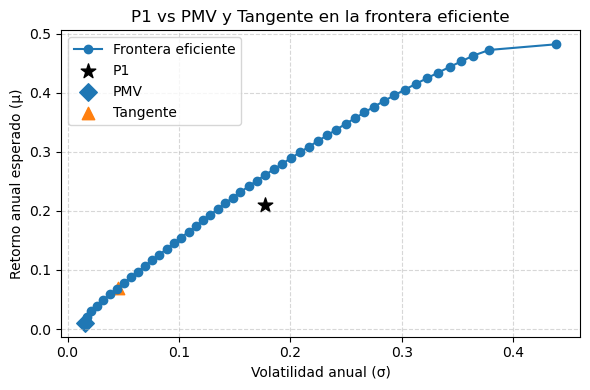

In [7]:
# ---------- PMV y Tangente para comparar con P1 ----------

pmv_info = dp_p1.pmv_info(mu_hist, Sigma_hist, long_only=True)
tan_info = dp_p1.tangency_portfolio(mu_hist, Sigma_hist, rf_ann=rf_ann_assumed, long_only=True)

# Construir tabla comparativa
comp_df = pd.DataFrame([
    {
        "Portafolio": "P1",
        "μ_ann": metrics_p1.ann_return,
        "σ_ann": metrics_p1.ann_vol,
        "Sharpe": metrics_p1.sharpe,
    },
    {
        "Portafolio": "PMV (mínima varianza)",
        "μ_ann": pmv_info["expected_return"],
        "σ_ann": pmv_info["volatility"],
        "Sharpe": (pmv_info["expected_return"] - rf_ann_assumed) / pmv_info["volatility"]
                  if pmv_info["volatility"] > 0 else np.nan,
    },
    {
        "Portafolio": "Tangente (máx. Sharpe)",
        "μ_ann": tan_info["expected_return"],
        "σ_ann": tan_info["volatility"],
        "Sharpe": tan_info["sharpe"],
    },
])

comp_df = comp_df.set_index("Portafolio")

print("\nTabla 4 – Comparación de P1 vs portafolios de referencia de Markowitz:")
print("Filas:\n"
      "  P1                 = portafolio con pesos fijos\n"
      "  PMV                = portafolio de mínima varianza (riesgo mínimo)\n"
      "  Tangente           = portafolio de máxima razón de Sharpe (vs rf=0)\n\n"
      "Columnas:\n"
      "  μ_ann  = retorno anual esperado\n"
      "  σ_ann  = volatilidad anual\n"
      "  Sharpe = relación retorno/riesgo.\n")
print(comp_df.round(4))

# (Opcional) Graficar P1 junto con PMV y Tangente sobre la frontera
plt.figure(figsize=(6, 4))
plt.plot(curve_p1["volatility"], curve_p1["expected_return"], "o-", label="Frontera eficiente")
plt.scatter(
    metrics_p1.ann_vol, metrics_p1.ann_return,
    marker="*", s=120, label="P1", color="black"
)
plt.scatter(
    pmv_info["volatility"], pmv_info["expected_return"],
    marker="D", s=80, label="PMV"
)
plt.scatter(
    tan_info["volatility"], tan_info["expected_return"],
    marker="^", s=80, label="Tangente"
)
plt.xlabel("Volatilidad anual (σ)")
plt.ylabel("Retorno anual esperado (μ)")
plt.title("P1 vs PMV y Tangente en la frontera eficiente")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Tabla 4 y gráfica: P1 vs PMV y portafolio Tangente en la frontera eficiente

En la figura vemos la **frontera eficiente de Markowitz** (curva azul) y tres puntos destacados:

- **P1 (estrella negra)**: nuestro portafolio con los pesos fijados a mano.
- **PMV (rombo azul)**: portafolio con el **menor riesgo posible** dentro del conjunto de activos.
- **Tangente (triángulo naranja)**: portafolio que ofrece el **mejor intercambio retorno/riesgo** (la mayor razón de Sharpe).

La **Tabla 4** resume sus números clave:

- **Retorno_anual**  
  Cuánto ha ganado, en promedio, cada portafolio por año según los datos históricos.

- **Riesgo_anual**  
  Qué tanto se ha movido ese portafolio en el tiempo (si es tranquilo o muy volátil).

- **Sharpe**  
  Cuánto retorno “extra” entrega el portafolio por cada unidad de riesgo, medido aquí contra una tasa libre de riesgo igual a 0.

Lectura rápida de los resultados:

- El **PMV** casi no asume riesgo y, por lo mismo, su retorno histórico es muy bajo; su función es ser el punto de referencia “más conservador posible”.
- El **portafolio Tangente** tiene algo más de riesgo que el PMV, pero una mejora importante en retorno y en Sharpe: es el punto más eficiente en términos de “retorno por unidad de riesgo”.
- Nuestro **P1** tiene un retorno anual alto (~21%) pero también un riesgo bastante mayor (~18%).  
  Su Sharpe es bueno (≈1.18), pero **peor que el del Tangente**, lo que indica que P1 está asumiendo más riesgo del necesario para el nivel de retorno que consigue.

En la gráfica se ve que el punto de P1 queda algo por debajo de la curva azul: esto significa que **existen combinaciones de los mismos activos que, con un riesgo similar al de P1, podrían ofrecer un retorno un poco mayor** (o, al revés, el mismo retorno con algo menos de riesgo). Esa es justamente la lógica de la frontera eficiente de Markowitz.


# SARIMA / SARIMAX

## Construir la serie de log-retornos del Portafolio 1

In [8]:
# 1) Retornos simples diarios de los activos del P1
rets_assets_simple_p1 = dp_p1.info.compute_returns(kind="simple")

print("\nTabla TS1 – Retornos simples diarios por activo (Portafolio 1):")
print(
    "Filas  = fechas de la muestra.\n"
    "Columnas = cada activo del Portafolio 1.\n"
    "Valor   = cambio porcentual diario del precio de cada activo (retorno simple diario).\n"
    "         Números positivos indican subidas, negativos caídas y valores cercanos a 0\n"
    "         movimientos muy pequeños. En días sin negociación de acciones (fines de semana),\n"
    "         algunos activos pueden mostrar retornos 0 porque su precio no cambia.\n"
)
print(rets_assets_simple_p1.head())


# 2) Retorno simple diario del portafolio P1 (combinación de los activos con sus pesos)
rets_port_p1 = rets_assets_simple_p1.dot(weights_p1)

print("\nTabla TS2 – Retornos simples diarios del Portafolio 1:")
print(
    "Columna única con el retorno simple diario del Portafolio 1.\n"
    "Cada valor es el resultado de combinar los retornos de todos los activos,\n"
    "ponderados por los pesos que definimos para P1.\n"
)
print(rets_port_p1.head())


# 3) Log-retornos diarios del portafolio: log(1 + r_t)
log_rets_port_p1 = np.log1p(rets_port_p1)
log_rets_port_p1.name = "log_ret_P1"

print("\nTabla TS3 – Log-retornos diarios del Portafolio 1:")
print(
    "Transformamos el retorno simple r_t en log(1 + r_t).\n"
    "Esta serie (log_ret_P1) es la que usaremos en los modelos AR, MA, ARMA y SARIMA,\n"
    "porque en finanzas suele comportarse mejor para este tipo de modelos.\n"
)
print(log_rets_port_p1.head())





Tabla TS1 – Retornos simples diarios por activo (Portafolio 1):
Filas  = fechas de la muestra.
Columnas = cada activo del Portafolio 1.
Valor   = cambio porcentual diario del precio de cada activo (retorno simple diario).
         Números positivos indican subidas, negativos caídas y valores cercanos a 0
         movimientos muy pequeños. En días sin negociación de acciones (fines de semana),
         algunos activos pueden mostrar retornos 0 porque su precio no cambia.

Ticker          AAPL   BTC-USD       GLD       JPM        KO      NVDA  \
Date                                                                     
2020-08-04  0.006678 -0.003597  0.021278 -0.005723  0.008423  0.019754   
2020-08-05  0.003625  0.048290  0.009283  0.017373  0.011352  0.005255   
2020-08-06  0.034889  0.002788  0.013274  0.000309  0.005506  0.004319   
2020-08-07 -0.022736 -0.015136 -0.015885  0.022007  0.006740 -0.011998   
2020-08-08  0.000000  0.013151  0.000000  0.000000  0.000000  0.000000   

Tick

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


## Crear el objeto de modelos financieros de series de tiempo

In [9]:
# ---------- Objeto de modelos de series de tiempo para P1 ----------

ts_p1 = FinancialForecastModels(series=log_rets_port_p1, name="Portafolio 1 – log-retornos")

print("\nComentario:")
print("ts_p1 es el objeto que concentra todo el análisis de series de tiempo")
print("para los log-retornos diarios del Portafolio 1 (P1).")



Comentario:
ts_p1 es el objeto que concentra todo el análisis de series de tiempo
para los log-retornos diarios del Portafolio 1 (P1).


## Ajuste AR(1), MA(1), ARMA(1,1) (define ar1_res, ma1_res, arma11_res)

In [10]:
# ---------- TS3.5 – Ajuste de modelos AR(1), MA(1) y ARMA(1,1) para el P1 ----------

# Modelo AR(1)
ar1_res = ts_p1.fit_arima(order=(1, 0, 0))

print("\nComentario AR(1):")
print("El resumen muestra los coeficientes del modelo AR(1) aplicado a los log-retornos del P1.")
print("Nos interesa que los residuos de este modelo se parezcan a ruido blanco,")
print("es decir, que no quede autocorrelación fuerte después del ajuste.")

# Modelo MA(1)
ma1_res = ts_p1.fit_arima(order=(0, 0, 1))

print("\nComentario MA(1):")
print("El resumen muestra los coeficientes del modelo MA(1) aplicado a los log-retornos del P1.")
print("Este modelo captura shocks transitorios en los retornos a corto plazo.")

# Modelo ARMA(1,1)
arma11_res = ts_p1.fit_arima(order=(1, 0, 1))

print("\nComentario ARMA(1,1):")
print("El resumen muestra los coeficientes del modelo ARMA(1,1) aplicado a los log-retornos del P1.")
print("Este modelo combina parte autorregresiva (AR) y de medias móviles (MA),")
print("y suele ser un punto de partida estándar en series financieras.")


                               SARIMAX Results                                
Dep. Variable:             log_ret_P1   No. Observations:                 1822
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5604.823
Date:                Sun, 23 Nov 2025   AIC                         -11203.646
Time:                        19:45:39   BIC                         -11187.123
Sample:                    08-04-2020   HQIC                        -11197.550
                         - 07-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.005      0.003       0.000       0.001
ar.L1         -0.0398      0.019     -2.130      0.033      -0.076      -0.003
sigma2         0.0001   2.26e-06     55.175      0.0

/home/fabianvs/miniconda3/envs/defi3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             log_ret_P1   No. Observations:                 1822
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5604.771
Date:                Sun, 23 Nov 2025   AIC                         -11203.542
Time:                        19:45:39   BIC                         -11187.019
Sample:                    08-04-2020   HQIC                        -11197.447
                         - 07-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.014      0.003       0.000       0.001
ma.L1         -0.0408      0.019     -2.202      0.028      -0.077      -0.004
sigma2         0.0001   2.26e-06     55.221      0.0

## Exploración básica (Box–Jenkins paso 1: identificación)

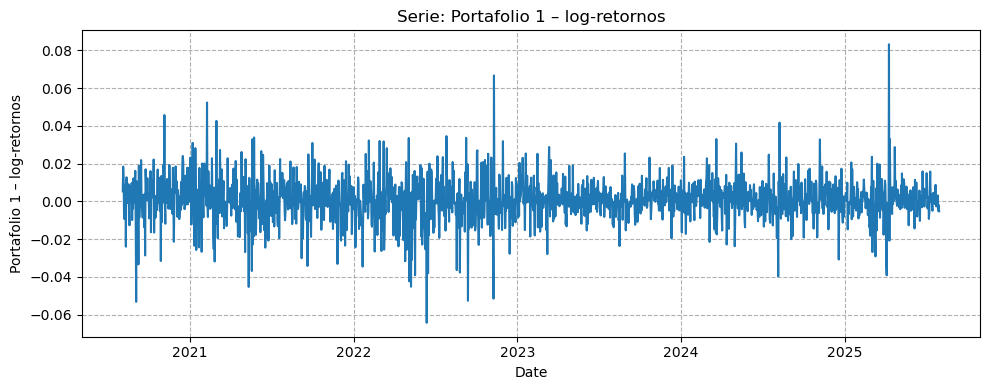


Comentario gráfico:
La figura muestra los log-retornos diarios del Portafolio 1 a lo largo del tiempo.
Visualmente buscamos que la serie oscile alrededor de cero, sin tendencia marcada
ni cambios fuertes en la escala. Ese comportamiento es lo que llamamos 'estacionario'.


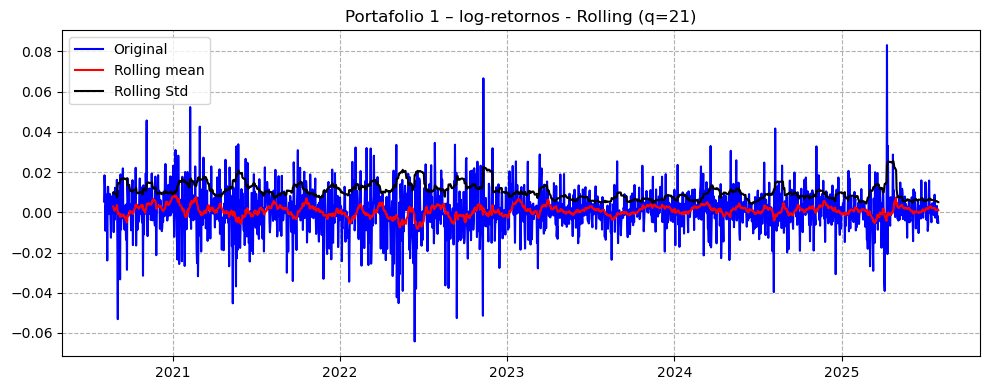


Comentario gráfico Rolling:
El gráfico de medias y desviaciones estándar móviles (ventana de 21 días)
resume cómo cambian el promedio y la variabilidad de los log-retornos en el tiempo.
Si ambas curvas se mantienen relativamente estables, es una señal adicional de
que la serie se comporta de forma aproximadamente estacionaria.
Resultados prueba Dickey-Fuller Aumentada:

        Values               Metrics
0   -44.381883       Test Statistics
1     0.000000               p-value
2     0.000000      No. of lags used
3  1821.000000          No. obs used
4    -3.433946   Critical Value (1%)
5    -2.863128   Critical Value (5%)
6    -2.567616  Critical Value (10%)

Comentario ADF:
La tabla recoge el estadístico de la prueba ADF y su p-valor.
Regla práctica: si el p-valor es menor que 0.05, rechazamos la hipótesis de
'no estacionariedad' y consideramos que la serie es estacionaria.
En retornos financieros es habitual obtener este tipo de resultado.


<Figure size 1000x400 with 0 Axes>

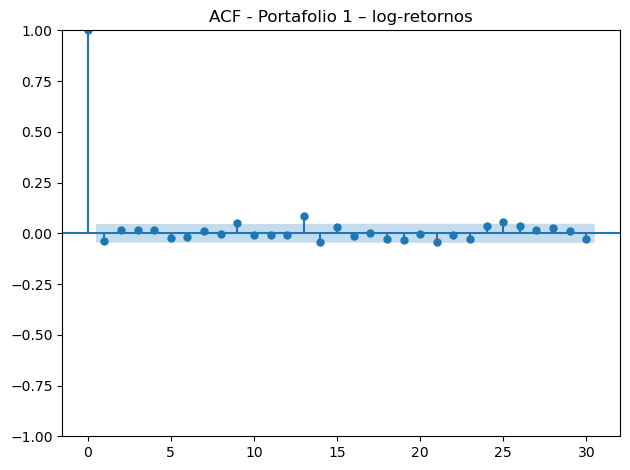

<Figure size 1000x400 with 0 Axes>

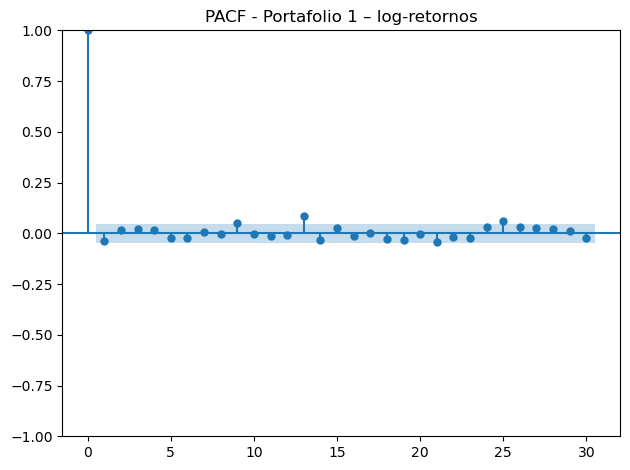


Comentario ACF/PACF:
Las gráficas ACF y PACF muestran cuánta memoria tiene la serie a distintos rezagos.
Que solo aparezcan pocos picos significativos sugiere usar modelos AR/MA/ARMA
de orden bajo (por ejemplo 1 ó 2), coherente con la práctica en series financieras.


In [11]:
# ---------- 3.1. Gráfico de la serie de log-retornos del P1 ----------
ts_p1.plot_series()

print("\nComentario gráfico:")
print("La figura muestra los log-retornos diarios del Portafolio 1 a lo largo del tiempo.")
print("Visualmente buscamos que la serie oscile alrededor de cero, sin tendencia marcada")
print("ni cambios fuertes en la escala. Ese comportamiento es lo que llamamos 'estacionario'.")

# ---------- 3.2. Rolling mean / std ----------
ts_p1.plot_rolling(q=21)  # ventana de ~1 mes de trading

print("\nComentario gráfico Rolling:")
print("El gráfico de medias y desviaciones estándar móviles (ventana de 21 días)")
print("resume cómo cambian el promedio y la variabilidad de los log-retornos en el tiempo.")
print("Si ambas curvas se mantienen relativamente estables, es una señal adicional de")
print("que la serie se comporta de forma aproximadamente estacionaria.")

# ---------- 3.3. Prueba de Dickey–Fuller Aumentada (ADF) ----------
adf_result_p1 = ts_p1.adf_test()

print("\nComentario ADF:")
print("La tabla recoge el estadístico de la prueba ADF y su p-valor.")
print("Regla práctica: si el p-valor es menor que 0.05, rechazamos la hipótesis de")
print("'no estacionariedad' y consideramos que la serie es estacionaria.")
print("En retornos financieros es habitual obtener este tipo de resultado.")

# ---------- 3.4. ACF y PACF ----------
ts_p1.plot_acf_pacf(lags=30)

print("\nComentario ACF/PACF:")
print("Las gráficas ACF y PACF muestran cuánta memoria tiene la serie a distintos rezagos.")
print("Que solo aparezcan pocos picos significativos sugiere usar modelos AR/MA/ARMA")
print("de orden bajo (por ejemplo 1 ó 2), coherente con la práctica en series financieras.")



### Comentario sobre la serie de log-retornos del Portafolio 1

- La serie de log-retornos diarios oscila alrededor de **cero**, sin una tendencia creciente o decreciente clara.
- Hay **picos aislados** (subidas o caídas bruscas), pero en general los movimientos diarios se mantienen en un rango relativamente acotado.
- A simple vista, el comportamiento parece compatible con un proceso **aproximadamente estacionario**: la media no cambia de forma sistemática y la variabilidad no explota en el tiempo.

---

### Comentario sobre medias y desvíos estándar móviles (rolling, ventana 21 días)

- La **media móvil** de 21 días (línea roja) se mantiene muy cerca de cero durante todo el periodo, lo que refuerza la idea de que el rendimiento esperado diario del portafolio es estable.
- La **desviación estándar móvil** (línea negra) muestra algunos periodos con volatilidad algo más alta y otros algo más baja, pero sin cambios estructurales extremos.
- En conjunto, el gráfico sugiere que la serie de log-retornos de P1 tiene un comportamiento razonablemente **estable en media y varianza**, lo que es coherente con la hipótesis de estacionariedad.

---

### Comentario sobre la prueba Dickey–Fuller Aumentada (ADF)

- El estadístico de prueba ADF es aproximadamente **−44.38**, mucho más negativo que los valores críticos al 1 %, 5 % y 10 %.
- El **p-valor es prácticamente 0.0000**, muy por debajo de 0.05.
- Esto nos permite **rechazar la hipótesis nula de “no estacionariedad”** y concluir que los log-retornos del Portafolio 1 pueden considerarse **estacionarios**.
- Este resultado es coherente con la evidencia empírica típica en finanzas: los retornos (y log-retornos) suelen comportarse como series estacionarias.

---

### Comentario sobre ACF y PACF

- En las gráficas de **ACF** y **PACF**, casi todos los coeficientes para rezagos mayores que 0 están **muy cerca de cero** y dentro de las bandas de confianza.
- Esto indica que **no hay una autocorrelación fuerte y persistente** en los log-retornos del portafolio: el valor de hoy aporta poca información sobre el de mañana.
- Dicho de otra forma, la serie se parece bastante a un **ruido blanco** (salvo pequeñas dependencias de corto plazo).
- Desde el punto de vista de modelado, esto sugiere que, si se usan modelos AR, MA o ARMA, deberán ser **muy parsimoniosos** (órdenes bajos como 1 o 2), y que el beneficio de modelos muy complejos será limitado.


## Pronósticos de corto/largo plazo con AR, MA, ARMA


Tabla TS4 – Pronósticos de log-retornos para el Portafolio 1 (P1):
Filas   = días futuros del horizonte de pronóstico (≈ 1 año hábil).
Columnas = modelo utilizado (AR(1), MA(1), ARMA(1,1)).
Valor    = log-retorno pronosticado del Portafolio 1 para cada día.

               AR(1)     MA(1)  ARMA(1,1)
2025-07-31  0.001007  0.001019   0.001003
2025-08-01  0.000759  0.000770   0.000721
2025-08-02  0.000769  0.000770   0.000780
2025-08-03  0.000768  0.000770   0.000767
2025-08-04  0.000769  0.000770   0.000770


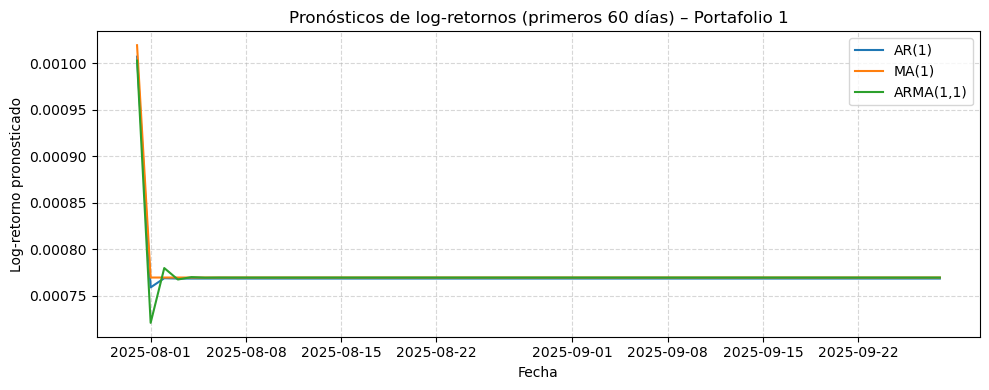


Comentario TS4 (pronósticos AR/MA/ARMA):
La tabla resume los primeros días de los log-retornos pronosticados por cada modelo.
El gráfico permite visualizar cómo evolucionan estos pronósticos en el corto plazo.
En series financieras de retornos, los valores suelen ser pequeños y cercanos a cero,
por lo que estos modelos son más útiles para generar escenarios y simulaciones
que para adivinar el retorno exacto de un día en particular.


In [12]:
# ---------- TS4 – Pronósticos AR(1), MA(1) y ARMA(1,1) para el P1 ----------

# Horizonte de pronóstico: 252 días hábiles ≈ 1 año de trading
horizon_days = 252

# Pronósticos de log-retornos con cada modelo
fc_ar1     = ar1_res.forecast(steps=horizon_days)      # AR(1)
fc_ma1     = ma1_res.forecast(steps=horizon_days)      # MA(1)
fc_arma11  = arma11_res.forecast(steps=horizon_days)   # ARMA(1,1)

# Tabla con los primeros pronósticos
fc_df = pd.DataFrame({
    "AR(1)":      fc_ar1,
    "MA(1)":      fc_ma1,
    "ARMA(1,1)":  fc_arma11,
})

print("\nTabla TS4 – Pronósticos de log-retornos para el Portafolio 1 (P1):")
print("Filas   = días futuros del horizonte de pronóstico (≈ 1 año hábil).")
print("Columnas = modelo utilizado (AR(1), MA(1), ARMA(1,1)).")
print("Valor    = log-retorno pronosticado del Portafolio 1 para cada día.\n")
print(fc_df.head())

# ---------- Gráfico comparando los tres modelos en los primeros 60 días ----------
plt.figure(figsize=(10, 4))
plt.plot(fc_ar1.iloc[:60].index,    fc_ar1.iloc[:60].values,    label="AR(1)")
plt.plot(fc_ma1.iloc[:60].index,    fc_ma1.iloc[:60].values,    label="MA(1)")
plt.plot(fc_arma11.iloc[:60].index, fc_arma11.iloc[:60].values, label="ARMA(1,1)")
plt.title("Pronósticos de log-retornos (primeros 60 días) – Portafolio 1")
plt.xlabel("Fecha")
plt.ylabel("Log-retorno pronosticado")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("\nComentario TS4 (pronósticos AR/MA/ARMA):")
print("La tabla resume los primeros días de los log-retornos pronosticados por cada modelo.")
print("El gráfico permite visualizar cómo evolucionan estos pronósticos en el corto plazo.")
print("En series financieras de retornos, los valores suelen ser pequeños y cercanos a cero,")
print("por lo que estos modelos son más útiles para generar escenarios y simulaciones")
print("que para adivinar el retorno exacto de un día en particular.")

### Comentario TS4 – Pronósticos AR(1), MA(1) y ARMA(1,1) para el Portafolio 1

La Tabla TS4 muestra, para los primeros días del horizonte de 1 año, los **log-retornos pronosticados** del Portafolio 1 bajo tres especificaciones: AR(1), MA(1) y ARMA(1,1).

- Todos los valores pronosticados son **muy pequeños y positivos (del orden de 0.0007–0.001)**, es decir, retornos diarios esperados cercanos a cero.
- Las diferencias entre modelos se concentran en los **primeros días**: AR(1) y MA(1) hacen un pequeño “salto” inicial y luego se acercan rápidamente al mismo nivel que ARMA(1,1).

En el gráfico de los **primeros 60 días de pronóstico** se observa que:

- Tras los primeros días, las tres curvas prácticamente **se superponen y se vuelven casi planas**, lo que indica que todos los modelos terminan apuntando al **mismo retorno medio** a largo plazo.
- No aparece ninguna señal de tendencia fuerte o patrón predecible; el mejor pronóstico de mañana es “casi igual” al de hoy.

En resumen, los modelos AR, MA y ARMA:

- Captan muy poca estructura predictiva en los log-retornos del portafolio (coherente con que la serie se comporta casi como ruido blanco).
- Son más útiles como **generadores de escenarios coherentes** (para simulaciones o ejercicios de estrés) que como herramientas para predecir con precisión el retorno de un día específico.


## SARIMA / SARIMAX para el Portafolio 1

                                     SARIMAX Results                                      
Dep. Variable:                         log_ret_P1   No. Observations:                 1822
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 21)   Log Likelihood                5601.612
Date:                            Sun, 23 Nov 2025   AIC                         -11193.225
Time:                                    19:45:42   BIC                         -11165.686
Sample:                                08-04-2020   HQIC                        -11183.066
                                     - 07-30-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1704      0.554     -0.308      0.758      -1.256       0.916
ma.L1          0.1342      0.555   

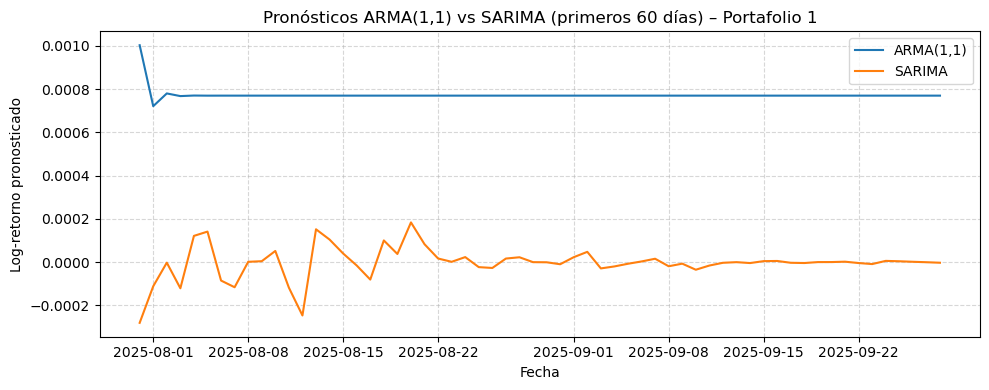


Comentario TS5 (SARIMA):
El modelo SARIMA permite introducir un componente estacional sobre los log-retornos.
En muchas series financieras, esta estacionalidad es débil, por lo que los pronósticos
de SARIMA y ARMA(1,1) pueden verse muy parecidos. Aun así, este bloque deja documentado
cómo incorporar esta estructura cuando la estacionalidad sea relevante.


In [13]:
# ---------- TS5 – Modelo SARIMA (vía SARIMAX) para log-retornos del P1 ----------

sarima_res_p1 = ts_p1.fit_sarimax_model(
    order=(1, 0, 1),           # parte no estacional (ARMA(1,1))
    seasonal_order=(1, 0, 1, 21),  # estacionalidad aproximada de 21 días (≈ 1 mes hábil)
)

# Pronóstico SARIMA para el mismo horizonte
fc_sarima_p1 = ts_p1.forecast_sarimax(steps=horizon_days)

print("\nTabla TS5 – Primeras filas de pronóstico SARIMA para log-retornos del P1:")
print(
    "Columna única con el log-retorno pronosticado vía un modelo SARIMA\n"
    "que combina parte ARMA(1,1) con una estacionalidad mensual aproximada (21 días hábiles).\n"
)
print(fc_sarima_p1.head())

# Comparar ARMA(1,1) vs SARIMA en los primeros 60 días de pronóstico
plt.figure(figsize=(10, 4))
plt.plot(fc_arma11.iloc[:60].index,  fc_arma11.iloc[:60].values,  label="ARMA(1,1)")
plt.plot(fc_sarima_p1.iloc[:60].index, fc_sarima_p1.iloc[:60].values, label="SARIMA")
plt.title("Pronósticos ARMA(1,1) vs SARIMA (primeros 60 días) – Portafolio 1")
plt.xlabel("Fecha")
plt.ylabel("Log-retorno pronosticado")
plt.grid(ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("\nComentario TS5 (SARIMA):")
print("El modelo SARIMA permite introducir un componente estacional sobre los log-retornos.")
print("En muchas series financieras, esta estacionalidad es débil, por lo que los pronósticos")
print("de SARIMA y ARMA(1,1) pueden verse muy parecidos. Aun así, este bloque deja documentado")
print("cómo incorporar esta estructura cuando la estacionalidad sea relevante.")


### Comentario TS5 – Modelo SARIMA para los log-retornos del Portafolio 1

El modelo ajustado es un **SARIMA(1,0,1) × (1,0,1)\_21** sobre la serie de log-retornos del Portafolio 1:

- La parte `(1,0,1)` corresponde a un **ARMA(1,1)** “normal”.
- La parte `(1,0,1,21)` añade un componente estacional con periodo de **21 días hábiles** (aprox. un mes de trading).

En el resumen de `SARIMAX Results` se observa que:

- Los coeficientes AR y MA (tanto normales como estacionales) tienen **p-values altos**, es decir, estadísticamente no son muy distintos de cero.
- El test de **Ljung–Box** sobre los residuos (Prob(Q) ≈ 0.88) indica que **no queda autocorrelación fuerte** en el primer rezago, lo que es coherente con que los log-retornos se comporten casi como ruido blanco.
- El test de **Jarque–Bera** tiene p-value ≈ 0, con curtosis alta (~8), lo que sugiere que los residuos **no son normales** y tienen colas más pesadas que una normal (algo típico en datos financieros).

En la figura de **pronósticos ARMA(1,1) vs SARIMA** (primeros 60 días):

- La curva de **ARMA(1,1)** es casi constante y ligeramente positiva, similar a lo que ya habíamos visto en TS4.
- La curva **SARIMA** oscila alrededor de cero con pequeñas variaciones, pero sin una tendencia marcada ni patrones grandes.

En conjunto, esto indica que:

- El componente estacional añadido por SARIMA **no introduce cambios drásticos** en los pronósticos respecto al ARMA(1,1); la serie de log-retornos sigue siendo difícil de predecir y se mueve alrededor de un valor medio muy pequeño.
- Aun así, el bloque deja documentado **cómo incorporar una estructura estacional** en el modelo por si en otros activos o ventanas de tiempo se detecta estacionalidad más clara.


# Merton 

##  M1/M2 – μ y Σ históricos para Merton

In [24]:
# ==============================================================
# Serie con retornos CAPM diarios por activo 
# ==============================================================

capm_rets_assets = pd.Series(
    {
        "SHY":     0.000127,
        "GLD":     0.000178,
        "TIP":     0.000152,
        "NVDA":    0.000847,
        "KO":      0.000213,
        "BTC-USD": 0.000467,
        "JPM":     0.000433,
        "TSLA":    0.000826,
        "AAPL":    0.000543,
        "IEF":     0.000142,
    },
    name="capm_ret_daily",
)

print("\nSerie CAPM – Retornos esperados diarios por activo (según el cálculo CAPM):")
print(
    "Índice = cada activo del universo (incluye los de P1 y P2).\n"
    "Valor  = retorno esperado diario por CAPM (en proporción, por ejemplo 0.0002 ≈ 0.02% diario).\n"
)
print(capm_rets_assets.round(6))
# ---------- Uso específico para el Portafolio 2 ----------

# Aseguramos que el orden de μ_CAPM diario siga el mismo orden de los activos del P1
# (suponiendo que dp_p1 es la instancia Do_portfolio del universo del P1)
mu_capm_daily_p1 = capm_rets_assets.reindex(dp_p1.info.data.columns)

# Retorno CAPM diario del portafolio 1 (P1) usando SUS pesos (weights_p1)
mu_capm_port1_daily = float(np.dot(weights_p1, mu_capm_daily_p1))

# Anualizamos para referencia (opcional)
periods_per_year = 252
mu_capm_port1_ann = mu_capm_port1_daily * periods_per_year
print("\nResumen CAPM – Portafolio 1 (P1):")
print(
    "mu_CAPM_P1_daily = retorno esperado diario del P1 según CAPM,\n"
    "                   calculado como suma(w_i * mu_CAPM_i) con los pesos del P1.\n"
    "mu_CAPM_P1_ann   = misma idea pero anualizada (multiplicando por 252).\n"
)
print(f"mu_CAPM_P1_daily = {mu_capm_port1_daily:.6f}")
print(f"mu_CAPM_P1_ann   = {mu_capm_port1_ann:.4f}")


Serie CAPM – Retornos esperados diarios por activo (según el cálculo CAPM):
Índice = cada activo del universo (incluye los de P1 y P2).
Valor  = retorno esperado diario por CAPM (en proporción, por ejemplo 0.0002 ≈ 0.02% diario).

SHY        0.000127
GLD        0.000178
TIP        0.000152
NVDA       0.000847
KO         0.000213
BTC-USD    0.000467
JPM        0.000433
TSLA       0.000826
AAPL       0.000543
IEF        0.000142
Name: capm_ret_daily, dtype: float64

Resumen CAPM – Portafolio 1 (P1):
mu_CAPM_P1_daily = retorno esperado diario del P1 según CAPM,
                   calculado como suma(w_i * mu_CAPM_i) con los pesos del P1.
mu_CAPM_P1_ann   = misma idea pero anualizada (multiplicando por 252).

mu_CAPM_P1_daily = 0.000403
mu_CAPM_P1_ann   = 0.1016


## M1 – μ por CAPM y Σ histórica para el universo del P1

In [15]:
# ---------- M1 – μ por CAPM y Σ histórica para el universo del P1 ----------

# Por si no está definido en este cuaderno
periods_per_year = 252  

# 1) Retornos simples diarios de los ACTIVOS (no del portafolio)
rets_simple_assets_p1 = dp_p1.info.compute_returns(kind="simple")

# 2) Rendimientos CAPM diarios por activo:
#    usamos la Serie capm_rets_assets que definimos en el bloque anterior
#    y la reindexamos para quedarnos solo con los activos que realmente están en el universo de P1.
mu_capm_daily_p1 = capm_rets_assets.reindex(rets_simple_assets_p1.columns)

# 3) μ anual para Merton a partir de CAPM
mu_hist_merton_p1 = mu_capm_daily_p1 * periods_per_year

# 4) Σ anual histórica (covarianza de los retornos simples)
Sigma_hist_merton_p1 = rets_simple_assets_p1.cov() * periods_per_year

print("\nTabla M1 – Rendimientos esperados anuales (μ) por activo – CAPM (P1):")
print(
    "Índice   = cada activo del universo del Portafolio 1.\n"
    "mu_ann   = retorno medio anual estimado con CAPM (beta de cada activo vs mercado).\n"
    "Interpretación: valores mayores indican activos con mayor prima de rendimiento\n"
    "según el modelo de CAPM, que es la μ que usará Merton para ese activo.\n"
)
print(mu_hist_merton_p1.to_frame("mu_ann_capm").round(4))

print("\nTabla M2 – Matriz de covarianzas anual (Σ) entre activos – estimación histórica (P1):")
print(
    "Filas/columnas = activos del universo del P1.\n"
    "Cada celda     = covarianza anual entre los retornos simples de dos activos.\n"
    "La diagonal    = varianza anual de cada activo; fuera de diagonal = co-movimiento conjunto.\n"
    "Esta Σ, junto con μ_ann_capm, es el insumo de riesgo que usa el modelo de Merton.\n"
)
print(Sigma_hist_merton_p1.round(4))



Tabla M1 – Rendimientos esperados anuales (μ) por activo – CAPM (P1):
Índice   = cada activo del universo del Portafolio 1.
mu_ann   = retorno medio anual estimado con CAPM (beta de cada activo vs mercado).
Interpretación: valores mayores indican activos con mayor prima de rendimiento
según el modelo de CAPM, que es la μ que usará Merton para ese activo.

         mu_ann_capm
Ticker              
AAPL          0.1368
BTC-USD       0.1177
GLD           0.0449
JPM           0.1091
KO            0.0537
NVDA          0.2134
SHY           0.0320
TIP           0.0383
TSLA          0.2082

Tabla M2 – Matriz de covarianzas anual (Σ) entre activos – estimación histórica (P1):
Filas/columnas = activos del universo del P1.
Cada celda     = covarianza anual entre los retornos simples de dos activos.
La diagonal    = varianza anual de cada activo; fuera de diagonal = co-movimiento conjunto.
Esta Σ, junto con μ_ann_capm, es el insumo de riesgo que usa el modelo de Merton.

Ticker     AAPL  BTC-USD 

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


## Tasa libre anual r_0 a partir de ^IRX

In [16]:
# ---------- M2 – Serie de tasa libre (^IRX) y tasa anual de referencia r0 ----------

# Usamos el mismo rango temporal que dp_p1 para la tasa libre
start_hist_p1 = dp_p1.start
end_hist_p1 = dp_p1.end

rf_ticker = "^IRX"

data_rf_p1 = yahoo_data.download_data(
    tickers=rf_ticker,
    start=start_hist_p1,
    end=end_hist_p1,
    price_col="Adj Close",
    auto_adjust=False,
)

# Convertimos de "% anual" a:
# - rf_ann  : tasa anual en proporción
# - rf_daily_log : log-retorno diario equivalente (no lo usaremos aquí, pero queda disponible)
rf_ann_p1, rf_daily_log_p1 = yahoo_data.convert_rf(
    data_rf_p1,
    days_per_year=periods_per_year,
    kind="log",
)

r0_p1 = float(rf_ann_p1.iloc[-1, 0])

print("\nTabla M3 – Tasa libre anual histórica (rf_ann) usada para Merton (P1):")
print(
    "Serie de la tasa libre anual en proporción (por ejemplo 0.05 = 5%).\n"
    "Tomamos como r0 el último valor disponible antes de la fecha de corte del análisis.\n"
)
print(rf_ann_p1.tail())

print(f"\nValor r0 (tasa libre anual de referencia para Merton en P1): {r0_p1:.4f}")



Tabla M3 – Tasa libre anual histórica (rf_ann) usada para Merton (P1):
Serie de la tasa libre anual en proporción (por ejemplo 0.05 = 5%).
Tomamos como r0 el último valor disponible antes de la fecha de corte del análisis.

            ^IRX_ann
Date                
2025-07-24   0.04245
2025-07-25   0.04245
2025-07-28   0.04235
2025-07-29   0.04230
2025-07-30   0.04232

Valor r0 (tasa libre anual de referencia para Merton en P1): 0.0423


## Pesos de Merton base

In [17]:
# ---------- M3 – Pesos de Merton para el universo del P1 ----------

# Parámetro de aversión al riesgo (puedes cambiarlo y analizar sensibilidad después)
gamma_p1 = 5.0  

pi_merton_p1 = Do_portfolio.merton_raw(
    r=pd.Series(r0_p1),         # se acepta float o Series; aquí imitamos tu uso original
    gamma=gamma_p1,
    Sigma=Sigma_hist_merton_p1,
    mu=mu_hist_merton_p1,
)

print("\nTabla M4 – Pesos de Merton (π) por activo – Portafolio 1 (universo de activos):")
print(
    "Índice       = activos del universo del P1.\n"
    "π_i (Merton) = peso óptimo en cada activo riesgoso según el modelo de Merton,\n"
    "               dados μ históricos, Σ histórica, tasa libre r0 y aversión γ.\n"
    "Importante: la suma de π puede ser distinta de 1; el resto iría a la tasa libre.\n"
)
print(pi_merton_p1.to_frame("pi_Merton").round(4))

# Suma total en activos riesgosos y peso implícito en tasa libre
sum_risky_p1 = float(pi_merton_p1.sum())
w_rf_impl_p1 = 1.0 - sum_risky_p1

print(f"\nSuma de pesos Merton en activos riesgosos (∑π): {sum_risky_p1:.4f}")
print(f"Peso implícito en tasa libre (1 - ∑π):         {w_rf_impl_p1:.4f}")

# Comparación rápida con el Portafolio 1 original
w_p1_series = pd.Series(weights_p1, index=dp_p1.tickers, name="P1_weights")

comp_merton_p1 = pd.concat([w_p1_series, pi_merton_p1], axis=1)
comp_merton_p1.columns = ["P1_weights", "Merton_pi"]

print("\nTabla M5 – Comparación de pesos: Portafolio 1 vs Merton (universo de activos):")
print(
    "P1_weights = pesos originales del Portafolio 1.\n"
    "Merton_pi  = pesos teóricos de Merton en los mismos activos.\n"
    "Esto permite ver en qué activos Merton es más agresivo o más conservador\n"
    "respecto al portafolio que propusiste originalmente.\n"
)
print(comp_merton_p1.round(4))



Tabla M4 – Pesos de Merton (π) por activo – Portafolio 1 (universo de activos):
Índice       = activos del universo del P1.
π_i (Merton) = peso óptimo en cada activo riesgoso según el modelo de Merton,
               dados μ históricos, Σ histórica, tasa libre r0 y aversión γ.
Importante: la suma de π puede ser distinta de 1; el resto iría a la tasa libre.

         pi_Merton
AAPL        0.1745
BTC-USD     0.0073
GLD         0.2540
JPM         0.0764
KO          0.0484
NVDA        0.0783
SHY       -14.0820
TIP         2.1741
TSLA        0.0172

Suma de pesos Merton en activos riesgosos (∑π): -11.2517
Peso implícito en tasa libre (1 - ∑π):         12.2517

Tabla M5 – Comparación de pesos: Portafolio 1 vs Merton (universo de activos):
P1_weights = pesos originales del Portafolio 1.
Merton_pi  = pesos teóricos de Merton en los mismos activos.
Esto permite ver en qué activos Merton es más agresivo o más conservador
respecto al portafolio que propusiste originalmente.

         P1_weights 

## Riesgo de tasa de interés en Merton (sensibilidad dπ/dr)

In [18]:
# ---------- M4 – Riesgo de tasa de interés en Merton: dπ/dr (P1) ----------

merton_irisk_p1 = dp_p1.interest_rate_risk_merton(
    gamma=gamma_p1,
    r0=r0_p1,
    dr=0.01,                 # incremento pequeño de tasa para derivada numérica (1%)
    use_bar=False,           # que estime μ y Σ directamente de los retornos diarios
    kind="simple",
    periods_per_year=periods_per_year,
)

pi_base_p1          = merton_irisk_p1["pi"]
dpi_dr_analytic_p1  = merton_irisk_p1["dpi_dr_analytic"]
dpi_dr_numeric_p1   = merton_irisk_p1["dpi_dr_numeric"]

irisk_table_p1 = pd.concat(
    [pi_base_p1, dpi_dr_analytic_p1, dpi_dr_numeric_p1],
    axis=1,
)
irisk_table_p1.columns = ["pi_Merton(r0)", "dπ/dr (analítica)", "dπ/dr (numérica)"]

print("\nTabla M6 – Riesgo de tasa de interés en el modelo de Merton (P1):")
print(
    "pi_Merton(r0)      = pesos de Merton evaluados en la tasa libre r0.\n"
    "dπ/dr (analítica)  = derivada exacta de los pesos respecto a la tasa libre r.\n"
    "dπ/dr (numérica)   = aproximación numérica usando un pequeño cambio dr.\n\n"
    "Interpretación: si la tasa libre sube 1 punto (por ejemplo de 4% a 5%),\n"
    "el peso óptimo en cada activo cambia aproximadamente en dπ/dr unidades.\n"
    "Valores negativos indican que, al subir las tasas, el modelo reduce la posición\n"
    "en ese activo riesgoso; valores positivos indican lo contrario.\n"
)
print(irisk_table_p1.round(6))



Tabla M6 – Riesgo de tasa de interés en el modelo de Merton (P1):
pi_Merton(r0)      = pesos de Merton evaluados en la tasa libre r0.
dπ/dr (analítica)  = derivada exacta de los pesos respecto a la tasa libre r.
dπ/dr (numérica)   = aproximación numérica usando un pequeño cambio dr.

Interpretación: si la tasa libre sube 1 punto (por ejemplo de 4% a 5%),
el peso óptimo en cada activo cambia aproximadamente en dπ/dr unidades.
Valores negativos indican que, al subir las tasas, el modelo reduce la posición
en ese activo riesgoso; valores positivos indican lo contrario.

         pi_Merton(r0)  dπ/dr (analítica)  dπ/dr (numérica)
AAPL         -0.389554           0.772106          0.772106
BTC-USD       0.249313           0.755448          0.755448
GLD           1.364615          16.018614         16.018614
JPM           0.075768         -12.600775        -12.600775
KO            0.732255           2.751904          2.751904
NVDA          0.428145          -1.109127         -1.109127
SHY  

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


## Escenarios de tasa (Vasicek + Merton)

In [19]:
# ---------- M5 – Escenarios de tasa con Vasicek + Merton (P1) ----------

merton_scenarios_p1 = dp_p1.merton_vasicek_scenarios(
    rf_series=rf_ann_p1,      # serie anual de tasa libre en proporción
    gamma=gamma_p1,
    horizonte_anios=1.0,      # horizonte de 1 año
    n_paths=1000,             # número de trayectorias de tasa
    pasos_por_anio=periods_per_year,
    use_bar=False,            # que estime μ y Σ de los retornos diarios
    kind="simple",
    periods_per_year=periods_per_year,
    seed=42,
)

summary_weights_p1      = merton_scenarios_p1["summary_weights"]
summary_total_risky_p1  = merton_scenarios_p1["summary_total_risky"]

print("\nTabla M7 – Estadísticos de pesos de Merton bajo escenarios de tasa (P1):")
print(
    "Cada fila = un activo del universo del P1.\n"
    "Las columnas (count, mean, std, percentiles, etc.) resumen la distribución\n"
    "de pesos óptimos de Merton al final del horizonte de 1 año, cuando la tasa libre\n"
    "sigue trayectorias simuladas con el modelo de Vasicek calibrado a rf_ann.\n"
)
print(summary_weights_p1.round(4))

print("\nTabla M8 – Estadísticos de la suma de pesos en activos riesgosos (∑π) bajo escenarios (P1):")
print(
    "Esta tabla resume cómo varía la exposición total a riesgo (suma de pesos riesgosos)\n"
    "cuando la tasa libre es estocástica. Permite ver si en escenarios de tasas altas\n"
    "el modelo tiende a reducir la proporción total invertida en activos riesgosos.\n"
)
print(summary_total_risky_p1.round(4))



Tabla M7 – Estadísticos de pesos de Merton bajo escenarios de tasa (P1):
Cada fila = un activo del universo del P1.
Las columnas (count, mean, std, percentiles, etc.) resumen la distribución
de pesos óptimos de Merton al final del horizonte de 1 año, cuando la tasa libre
sigue trayectorias simuladas con el modelo de Vasicek calibrado a rf_ann.

          count     mean     std      min       5%      50%      95%      max
AAPL     1000.0  -0.3851  0.0039  -0.3997  -0.3912  -0.3851  -0.3787  -0.3717
BTC-USD  1000.0   0.2537  0.0039   0.2394   0.2477   0.2536   0.2599   0.2668
GLD      1000.0   1.4579  0.0818   1.1546   1.3296   1.4564   1.5890   1.7345
JPM      1000.0   0.0024  0.0644  -0.2152  -0.1008   0.0036   0.1033   0.2409
KO       1000.0   0.7483  0.0141   0.6962   0.7262   0.7480   0.7708   0.7958
NVDA     1000.0   0.4217  0.0057   0.4025   0.4126   0.4218   0.4306   0.4427
SHY      1000.0 -49.2366  6.3825 -70.8164 -59.4666 -49.1185 -39.2303 -25.5846
TIP      1000.0   5.4258  0.

/media/fabianvs/informacion/universidad/Defi 3/portafolio_de_inversion/function/yahoo_data.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.rets = self.data.pct_change()


# Reporte de metricas
## Sharpe con TBIL (^IRX) como tasa libre de riesgo

In [20]:
# ==============================================================
# Sharpe con TBIL (^IRX) como tasa libre de riesgo – Portafolio 1
# ==============================================================

# Usamos la tasa libre anual r0_p1 que ya construimos a partir de ^IRX:
#   - rf_ann_p1 : serie anual de TBIL en proporción (0.05 = 5%)
#   - r0_p1     : último valor de esa serie (tasa actual de referencia)
# Si r0_p1 aún no existe, asegúrate de correr antes el bloque donde se definió.

print("\nValor de referencia de la tasa libre anual (TBIL/^IRX) para P1:")
print(
    "r0_p1 = último dato anual de la serie rf_ann_p1, construida a partir de ^IRX.\n"
    "Lo usamos como tasa libre de riesgo en el cálculo del ratio de Sharpe,\n"
    "tal como pide el enunciado (TBIL como proxy de tasa libre).\n"
)
print(f"r0_p1 = {r0_p1:.4f}")

# Construimos una nueva tabla de comparación, pero ahora el Sharpe se calcula como:
#   Sharpe_TBIL = (μ_ann - r0_p1) / σ_ann
# para P1, PMV y Tangente, SIN cambiar los μ ni las σ que ya teníamos.

sharpe_tbil_p1 = pd.DataFrame([
    {
        "Portafolio": "P1",
        "μ_ann": metrics_p1.ann_return,
        "σ_ann": metrics_p1.ann_vol,
    },
    {
        "Portafolio": "PMV (mínima varianza)",
        "μ_ann": pmv_info["expected_return"],
        "σ_ann": pmv_info["volatility"],
    },
    {
        "Portafolio": "Tangente (máx. Sharpe)",
        "μ_ann": tan_info["expected_return"],
        "σ_ann": tan_info["volatility"],
    },
])

# Cálculo del Sharpe usando TBIL como tasa libre
sharpe_tbil_p1["Sharpe_TBIL"] = (
    sharpe_tbil_p1["μ_ann"] - r0_p1
) / sharpe_tbil_p1["σ_ann"]

sharpe_tbil_p1 = sharpe_tbil_p1.set_index("Portafolio")

print("\nTabla 4b – Ratio de Sharpe usando TBIL (^IRX) como tasa libre de riesgo (P1):")
print(
    "Filas:\n"
    "  P1                 = portafolio con pesos fijos.\n"
    "  PMV                = portafolio de mínima varianza (riesgo mínimo).\n"
    "  Tangente           = portafolio de máxima razón de Sharpe (obtenido con Markowitz).\n\n"
    "Columnas:\n"
    "  μ_ann       = retorno anual esperado del portafolio.\n"
    "  σ_ann       = volatilidad anual del portafolio.\n"
    "  Sharpe_TBIL = (μ_ann - r0_p1) / σ_ann, donde r0_p1 es la tasa anual de TBIL (^IRX).\n"
    "                Este es el Sharpe exactamente como lo pide la rúbrica del trabajo.\n"
)
print(sharpe_tbil_p1.round(4))



Valor de referencia de la tasa libre anual (TBIL/^IRX) para P1:
r0_p1 = último dato anual de la serie rf_ann_p1, construida a partir de ^IRX.
Lo usamos como tasa libre de riesgo en el cálculo del ratio de Sharpe,
tal como pide el enunciado (TBIL como proxy de tasa libre).

r0_p1 = 0.0423

Tabla 4b – Ratio de Sharpe usando TBIL (^IRX) como tasa libre de riesgo (P1):
Filas:
  P1                 = portafolio con pesos fijos.
  PMV                = portafolio de mínima varianza (riesgo mínimo).
  Tangente           = portafolio de máxima razón de Sharpe (obtenido con Markowitz).

Columnas:
  μ_ann       = retorno anual esperado del portafolio.
  σ_ann       = volatilidad anual del portafolio.
  Sharpe_TBIL = (μ_ann - r0_p1) / σ_ann, donde r0_p1 es la tasa anual de TBIL (^IRX).
                Este es el Sharpe exactamente como lo pide la rúbrica del trabajo.

                         μ_ann   σ_ann  Sharpe_TBIL
Portafolio                                         
P1                      0.2

## Ratio de Treynor para el Portafolio 1 (benchmark: SPY, rf: TBIL)

In [21]:
# ==============================================================
# Ratio de Treynor para el Portafolio 1 (benchmark: SPY, rf: TBIL)
# ==============================================================

# Usamos:
# - rets_port_p1 : retornos simples diarios del P1 (ya calculados antes)
# - r0_p1        : tasa libre anual de TBIL (^IRX) usada también en el Sharpe_TBIL
# - periods_per_year : número de días hábiles por año (252)
# - dp_p1        : instancia Do_portfolio del universo del P1
# - yahoo_data   : ya importado en este cuaderno

# 1) Descarga precios de SPY en la misma ventana temporal que P1
prices_spy = yahoo_data.download_data(
    tickers="SPY",
    start=dp_p1.start,
    end=dp_p1.end,
    price_col="Adj Close",
    auto_adjust=False,
)

# Retornos simples diarios de SPY
rets_spy = prices_spy.pct_change().dropna()

# Si viene como DataFrame de una sola columna, lo pasamos a Serie
if isinstance(rets_spy, pd.DataFrame):
    rets_spy = rets_spy.iloc[:, 0]

# 2) Alineamos los retornos diarios de P1 y SPY en las mismas fechas
common_idx = rets_port_p1.index.intersection(rets_spy.index)
rp = rets_port_p1.loc[common_idx]   # retornos diarios P1
rm = rets_spy.loc[common_idx]       # retornos diarios SPY

# 3) Beta del P1 respecto a SPY: Cov(r_P1, r_SPY) / Var(r_SPY)
cov_rp_rm = np.cov(rp, rm, ddof=1)[0, 1]
var_rm    = np.var(rm, ddof=1)
beta_p1   = cov_rp_rm / var_rm

# 4) Retorno anualizado del P1 y Treynor con TBIL como rf
mu_p1_ann_from_daily = rp.mean() * periods_per_year
treynor_p1 = (mu_p1_ann_from_daily - r0_p1) / beta_p1

# 5) Tabla resumen
treynor_df_p1 = pd.DataFrame(
    {
        "μ_ann (P1)":        [mu_p1_ann_from_daily],
        "β_P1_SPY":          [beta_p1],
        "rf_ann (TBIL)":     [r0_p1],
        "Treynor_SPY_TBIL":  [treynor_p1],
    },
    index=["P1"],
)

print("\nTabla 4c – Ratio de Treynor del Portafolio 1 (benchmark: SPY, rf: TBIL/^IRX):")
print(
    "Filas:\n"
    "  P1 = Portafolio 1 con sus pesos originales.\n\n"
    "Columnas:\n"
    "  μ_ann (P1)        = retorno anualizado del P1, calculado desde retornos diarios.\n"
    "  β_P1_SPY          = beta del P1 frente a SPY (sensibilidad al mercado).\n"
    "  rf_ann (TBIL)     = tasa libre anual estimada a partir de TBIL (^IRX).\n"
    "  Treynor_SPY_TBIL  = (μ_ann(P1) - rf_ann) / β_P1_SPY.\n"
    "                     Mide el exceso de retorno del P1 por unidad de riesgo\n"
    "                     sistemático (riesgo de mercado medido por beta).\n"
)
print(treynor_df_p1.round(4))


Tabla 4c – Ratio de Treynor del Portafolio 1 (benchmark: SPY, rf: TBIL/^IRX):
Filas:
  P1 = Portafolio 1 con sus pesos originales.

Columnas:
  μ_ann (P1)        = retorno anualizado del P1, calculado desde retornos diarios.
  β_P1_SPY          = beta del P1 frente a SPY (sensibilidad al mercado).
  rf_ann (TBIL)     = tasa libre anual estimada a partir de TBIL (^IRX).
  Treynor_SPY_TBIL  = (μ_ann(P1) - rf_ann) / β_P1_SPY.
                     Mide el exceso de retorno del P1 por unidad de riesgo
                     sistemático (riesgo de mercado medido por beta).

    μ_ann (P1)  β_P1_SPY  rf_ann (TBIL)  Treynor_SPY_TBIL
P1      0.2627    0.8659         0.0423            0.2545


## VaR histórico / paramétrico y CVaR (Expected Shortfall) – P1

In [22]:
# ==============================================================
# VaR histórico / paramétrico y CVaR (Expected Shortfall) – P1
# ==============================================================

from scipy.stats import norm

# Usamos:
# - rets_port_p1 : retornos simples diarios del P1 (ya definidos antes)
# - r0_p1        : tasa libre anual de TBIL (^IRX), por si queremos comparar
# - periods_per_year : número de días hábiles (252)

# Limpiamos retornos y fijamos parámetros de riesgo
rets_p1 = rets_port_p1.dropna()
alpha = 0.05               # nivel 5%  -> confianza 95%
V0 = 100_000.0             # capital de referencia para expresar pérdidas en dinero

# 1) VaR y CVaR HISTÓRICOS (basados directamente en la muestra de retornos)

# Percentil 5% de los retornos diarios (suele ser un número NEGATIVO)
var_hist_ret = np.quantile(rets_p1, alpha)

# CVaR histórico: media de los retornos que están por debajo del VaR
cvar_hist_ret = rets_p1[rets_p1 <= var_hist_ret].mean()

# Lo expresamos como pérdida positiva sobre el capital V0
var_hist_loss  = -var_hist_ret * V0
cvar_hist_loss = -cvar_hist_ret * V0

# 2) VaR y CVaR PARAMÉTRICOS (asumiendo retornos ~ Normal)

mu_d = rets_p1.mean()
sigma_d = rets_p1.std(ddof=1)
z_alpha = norm.ppf(alpha)

# VaR paramétrico (en retornos)
var_param_ret = mu_d + sigma_d * z_alpha
# CVaR paramétrico bajo Normal
cvar_param_ret = mu_d - sigma_d * norm.pdf(z_alpha) / alpha

# En pérdida monetaria sobre V0
var_param_loss  = -var_param_ret * V0
cvar_param_loss = -cvar_param_ret * V0

# 3) Tabla resumen

var_cvar_p1 = pd.DataFrame(
    {
        "VaR_hist_ret":      [var_hist_ret],
        "CVaR_hist_ret":     [cvar_hist_ret],
        "VaR_param_ret":     [var_param_ret],
        "CVaR_param_ret":    [cvar_param_ret],
        "VaR_hist_loss":     [var_hist_loss],
        "CVaR_hist_loss":    [cvar_hist_loss],
        "VaR_param_loss":    [var_param_loss],
        "CVaR_param_loss":   [cvar_param_loss],
    },
    index=["P1"],
)

print("\nTabla 5 – VaR y CVaR diarios del Portafolio 1 (P1):")
print(
    "Configuración:\n"
    f"  • Horizonte: 1 día hábil.\n"
    f"  • Nivel de confianza: 95% (alpha = {alpha}).\n"
    f"  • Capital de referencia: V0 = {V0:,.0f}.\n\n"
    "Columnas en retornos (ret):\n"
    "  VaR_hist_ret    = percentil 5% de los retornos diarios observados.\n"
    "  CVaR_hist_ret   = promedio de los retornos por debajo de ese percentil (cola izquierda).\n"
    "  VaR_param_ret   = VaR diario asumiendo distribución Normal (mu, sigma de la muestra).\n"
    "  CVaR_param_ret  = Expected Shortfall bajo Normal.\n\n"
    "Columnas en pérdida monetaria (loss):\n"
    "  VaR_hist_loss   = pérdida diaria máxima esperada (en pesos) con 95% de confianza,\n"
    "                    usando el VaR histórico.\n"
    "  CVaR_hist_loss  = pérdida media condicional cuando estamos en el 5% peor de los días.\n"
    "  VaR_param_loss  = análogo, pero con la aproximación Normal.\n"
    "  CVaR_param_loss = análogo, Expected Shortfall paramétrico.\n"
)
print(var_cvar_p1.round(4))


Tabla 5 – VaR y CVaR diarios del Portafolio 1 (P1):
Configuración:
  • Horizonte: 1 día hábil.
  • Nivel de confianza: 95% (alpha = 0.05).
  • Capital de referencia: V0 = 100,000.

Columnas en retornos (ret):
  VaR_hist_ret    = percentil 5% de los retornos diarios observados.
  CVaR_hist_ret   = promedio de los retornos por debajo de ese percentil (cola izquierda).
  VaR_param_ret   = VaR diario asumiendo distribución Normal (mu, sigma de la muestra).
  CVaR_param_ret  = Expected Shortfall bajo Normal.

Columnas en pérdida monetaria (loss):
  VaR_hist_loss   = pérdida diaria máxima esperada (en pesos) con 95% de confianza,
                    usando el VaR histórico.
  CVaR_hist_loss  = pérdida media condicional cuando estamos en el 5% peor de los días.
  VaR_param_loss  = análogo, pero con la aproximación Normal.
  CVaR_param_loss = análogo, Expected Shortfall paramétrico.

    VaR_hist_ret  CVaR_hist_ret  VaR_param_ret  CVaR_param_ret  VaR_hist_loss  \
P1       -0.0171        -0.02

## Máximo Drawdown y duración – Portafolio 1

In [23]:
# ==============================================================
# Máximo Drawdown y duración – Portafolio 1
# ==============================================================

# Construimos la serie de valores del portafolio P1 con buy & hold:
# V_t = V0 * ∏ (1 + r_t)
values_p1 = pd.DataFrame(
    {
        "P1": (1.0 + rets_p1).cumprod() * V0
    },
    index=rets_p1.index,
)

# Usamos la función de Do_portfolio para obtener tabla de drawdowns y duraciones
dd_table_p1 = Do_portfolio.dd_table(values_p1)

print("\nTabla 6 – Máximo Drawdown y duración del Portafolio 1 (P1):")
print(
    "Cada fila corresponde al Portafolio 1.\n\n"
    "Columnas principales:\n"
    "  MaxDD           = caída máxima relativa desde un pico hasta un valle (número negativo).\n"
    "  PeakDate        = fecha del máximo histórico antes de la caída más profunda.\n"
    "  TroughDate      = fecha del valle (mínimo) durante esa caída.\n"
    "  RecoveryDate    = primera fecha posterior en la que el portafolio recupera el nivel\n"
    "                    del pico (NaT si aún no recupera).\n"
    "  Days_Peak2Trough = número de días entre el pico y el valle (duración de la caída).\n"
    "  Days_Trough2Rec  = número de días entre el valle y la recuperación (duración de la\n"
    "                     fase de recuperación, si existe).\n"
    "\n"
    "Esta tabla resume tanto la profundidad como la duración de la peor racha del P1\n"
    "durante la muestra analizada.\n"
)
print(dd_table_p1)


Tabla 6 – Máximo Drawdown y duración del Portafolio 1 (P1):
Cada fila corresponde al Portafolio 1.

Columnas principales:
  MaxDD           = caída máxima relativa desde un pico hasta un valle (número negativo).
  PeakDate        = fecha del máximo histórico antes de la caída más profunda.
  TroughDate      = fecha del valle (mínimo) durante esa caída.
  RecoveryDate    = primera fecha posterior en la que el portafolio recupera el nivel
                    del pico (NaT si aún no recupera).
  Days_Peak2Trough = número de días entre el pico y el valle (duración de la caída).
  Days_Trough2Rec  = número de días entre el valle y la recuperación (duración de la
                     fase de recuperación, si existe).

Esta tabla resume tanto la profundidad como la duración de la peor racha del P1
durante la muestra analizada.

               MaxDD   PeakDate TroughDate RecoveryDate  Days_Peak2Trough  \
Portafolio                                                                  
P1         -